In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v031.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/notebooks


In [2]:
import sys, os, pathlib
import numpy as np
import xarray as xr
import torch
torch.backends.cudnn.enabled = True
import matplotlib.pyplot as plt
import seaborn as sns

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

Using backend: pytorch



True

In [3]:
%autoreload

#cohort = mre_pinn.data.PatientCohort(patient_ids=['0006', '0020'], xarray_dir='../data/NAFLD')
cohort = mre_pinn.data.PatientCohort.from_file('../data/NAFLD/NAFLD_2022-11-7.xarrays', xarray_dir='../data/NAFLD')
#cohort.create_xarrays()
#cohort.save_xarrays()
#cohort.metadata
cohort.load_xarrays()
cohort.eval_baseline()

/ocean/projects/asc170022p/shared/Data/MRE/MRE_DICOM_7-31-19/NIFTI/0213 is missing sequences {'t2', 'mre', 'wave', 'mre_raw'}
  0%|          | 0/155 [00:00<?, ?it/s]Loading ../data/NAFLD/0898/t1_pre_in.nc
Loading ../data/NAFLD/0898/t1_pre_water.nc
Loading ../data/NAFLD/0898/t1_pre_out.nc
Loading ../data/NAFLD/0898/t1_pre_fat.nc
Loading ../data/NAFLD/0898/t2.nc
Loading ../data/NAFLD/0898/mre_raw.nc
Loading ../data/NAFLD/0898/wave.nc
Loading ../data/NAFLD/0898/mre.nc
Loading ../data/NAFLD/0898/anat_mask.nc
Loading ../data/NAFLD/0898/mre_mask.nc
  1%|          | 1/155 [00:00<00:57,  2.69it/s]Loading ../data/NAFLD/0900/t1_pre_in.nc
Loading ../data/NAFLD/0900/t1_pre_water.nc
Loading ../data/NAFLD/0900/t1_pre_out.nc
Loading ../data/NAFLD/0900/t1_pre_fat.nc
Loading ../data/NAFLD/0900/t2.nc
Loading ../data/NAFLD/0900/mre_raw.nc
Loading ../data/NAFLD/0900/wave.nc
Loading ../data/NAFLD/0900/mre.nc
Loading ../data/NAFLD/0900/anat_mask.nc
Loading ../data/NAFLD/0900/mre_mask.nc
  1%|▏         | 2/1

Loading ../data/NAFLD/1077/anat_mask.nc
Loading ../data/NAFLD/1077/mre_mask.nc
 12%|█▏        | 19/155 [00:07<00:52,  2.61it/s]Loading ../data/NAFLD/1083/t1_pre_in.nc
Loading ../data/NAFLD/1083/t1_pre_water.nc
Loading ../data/NAFLD/1083/t1_pre_out.nc
Loading ../data/NAFLD/1083/t1_pre_fat.nc
Loading ../data/NAFLD/1083/t2.nc
Loading ../data/NAFLD/1083/mre_raw.nc
Loading ../data/NAFLD/1083/wave.nc
Loading ../data/NAFLD/1083/mre.nc
Loading ../data/NAFLD/1083/anat_mask.nc
Loading ../data/NAFLD/1083/mre_mask.nc
 13%|█▎        | 20/155 [00:08<00:48,  2.76it/s]Loading ../data/NAFLD/1103/t1_pre_in.nc
Loading ../data/NAFLD/1103/t1_pre_water.nc
Loading ../data/NAFLD/1103/t1_pre_out.nc
Loading ../data/NAFLD/1103/t1_pre_fat.nc
Loading ../data/NAFLD/1103/t2.nc
Loading ../data/NAFLD/1103/mre_raw.nc
Loading ../data/NAFLD/1103/wave.nc
Loading ../data/NAFLD/1103/mre.nc
Loading ../data/NAFLD/1103/anat_mask.nc
Loading ../data/NAFLD/1103/mre_mask.nc
 14%|█▎        | 21/155 [00:08<00:46,  2.86it/s]Loading .

Loading ../data/NAFLD/1303/anat_mask.nc
Loading ../data/NAFLD/1303/mre_mask.nc
 25%|██▍       | 38/155 [00:15<00:48,  2.43it/s]Loading ../data/NAFLD/1311/t1_pre_in.nc
Loading ../data/NAFLD/1311/t1_pre_water.nc
Loading ../data/NAFLD/1311/t1_pre_out.nc
Loading ../data/NAFLD/1311/t1_pre_fat.nc
Loading ../data/NAFLD/1311/t2.nc
Loading ../data/NAFLD/1311/mre_raw.nc
Loading ../data/NAFLD/1311/wave.nc
Loading ../data/NAFLD/1311/mre.nc
Loading ../data/NAFLD/1311/anat_mask.nc
Loading ../data/NAFLD/1311/mre_mask.nc
 25%|██▌       | 39/155 [00:15<00:44,  2.58it/s]Loading ../data/NAFLD/1230/t1_pre_in.nc
Loading ../data/NAFLD/1230/t1_pre_water.nc
Loading ../data/NAFLD/1230/t1_pre_out.nc
Loading ../data/NAFLD/1230/t1_pre_fat.nc
Loading ../data/NAFLD/1230/t2.nc
Loading ../data/NAFLD/1230/mre_raw.nc
Loading ../data/NAFLD/1230/wave.nc
Loading ../data/NAFLD/1230/mre.nc
Loading ../data/NAFLD/1230/anat_mask.nc
Loading ../data/NAFLD/1230/mre_mask.nc
 26%|██▌       | 40/155 [00:15<00:44,  2.58it/s]Loading .

Loading ../data/NAFLD/1456/anat_mask.nc
Loading ../data/NAFLD/1456/mre_mask.nc
 37%|███▋      | 57/155 [00:22<00:35,  2.74it/s]Loading ../data/NAFLD/1464/t1_pre_in.nc
Loading ../data/NAFLD/1464/t1_pre_water.nc
Loading ../data/NAFLD/1464/t1_pre_out.nc
Loading ../data/NAFLD/1464/t1_pre_fat.nc
Loading ../data/NAFLD/1464/t2.nc
Loading ../data/NAFLD/1464/mre_raw.nc
Loading ../data/NAFLD/1464/wave.nc
Loading ../data/NAFLD/1464/mre.nc
Loading ../data/NAFLD/1464/anat_mask.nc
Loading ../data/NAFLD/1464/mre_mask.nc
 37%|███▋      | 58/155 [00:22<00:36,  2.69it/s]Loading ../data/NAFLD/0006/t1_pre_in.nc
Loading ../data/NAFLD/0006/t1_pre_water.nc
Loading ../data/NAFLD/0006/t1_pre_out.nc
Loading ../data/NAFLD/0006/t1_pre_fat.nc
Loading ../data/NAFLD/0006/t2.nc
Loading ../data/NAFLD/0006/mre_raw.nc
Loading ../data/NAFLD/0006/wave.nc
Loading ../data/NAFLD/0006/mre.nc
Loading ../data/NAFLD/0006/anat_mask.nc
Loading ../data/NAFLD/0006/mre_mask.nc
 38%|███▊      | 59/155 [00:22<00:34,  2.80it/s]Loading .

Loading ../data/NAFLD/0401/anat_mask.nc
Loading ../data/NAFLD/0401/mre_mask.nc
 49%|████▉     | 76/155 [00:31<00:33,  2.33it/s]Loading ../data/NAFLD/0415/t1_pre_in.nc
Loading ../data/NAFLD/0415/t1_pre_water.nc
Loading ../data/NAFLD/0415/t1_pre_out.nc
Loading ../data/NAFLD/0415/t1_pre_fat.nc
Loading ../data/NAFLD/0415/t2.nc
Loading ../data/NAFLD/0415/mre_raw.nc
Loading ../data/NAFLD/0415/wave.nc
Loading ../data/NAFLD/0415/mre.nc
Loading ../data/NAFLD/0415/anat_mask.nc
Loading ../data/NAFLD/0415/mre_mask.nc
 50%|████▉     | 77/155 [00:31<00:31,  2.50it/s]Loading ../data/NAFLD/2007/t1_pre_in.nc
Loading ../data/NAFLD/2007/t1_pre_water.nc
Loading ../data/NAFLD/2007/t1_pre_out.nc
Loading ../data/NAFLD/2007/t1_pre_fat.nc
Loading ../data/NAFLD/2007/t2.nc
Loading ../data/NAFLD/2007/mre_raw.nc
Loading ../data/NAFLD/2007/wave.nc
Loading ../data/NAFLD/2007/mre.nc
Loading ../data/NAFLD/2007/anat_mask.nc
Loading ../data/NAFLD/2007/mre_mask.nc
 50%|█████     | 78/155 [00:32<00:28,  2.68it/s]Loading .

 61%|██████▏   | 95/155 [00:39<00:26,  2.24it/s]Loading ../data/NAFLD/0604/t1_pre_in.nc
Loading ../data/NAFLD/0604/t1_pre_water.nc
Loading ../data/NAFLD/0604/t1_pre_out.nc
Loading ../data/NAFLD/0604/t1_pre_fat.nc
Loading ../data/NAFLD/0604/t2.nc
Loading ../data/NAFLD/0604/mre_raw.nc
Loading ../data/NAFLD/0604/wave.nc
Loading ../data/NAFLD/0604/mre.nc
Loading ../data/NAFLD/0604/anat_mask.nc
Loading ../data/NAFLD/0604/mre_mask.nc
 62%|██████▏   | 96/155 [00:39<00:23,  2.52it/s]Loading ../data/NAFLD/0612/t1_pre_in.nc
Loading ../data/NAFLD/0612/t1_pre_water.nc
Loading ../data/NAFLD/0612/t1_pre_out.nc
Loading ../data/NAFLD/0612/t1_pre_fat.nc
Loading ../data/NAFLD/0612/t2.nc
Loading ../data/NAFLD/0612/mre_raw.nc
Loading ../data/NAFLD/0612/wave.nc
Loading ../data/NAFLD/0612/mre.nc
Loading ../data/NAFLD/0612/anat_mask.nc
Loading ../data/NAFLD/0612/mre_mask.nc
 63%|██████▎   | 97/155 [00:40<00:22,  2.61it/s]Loading ../data/NAFLD/0615/t1_pre_in.nc
Loading ../data/NAFLD/0615/t1_pre_water.nc
Loadi

 74%|███████▎  | 114/155 [00:46<00:15,  2.65it/s]Loading ../data/NAFLD/1671/t1_pre_in.nc
Loading ../data/NAFLD/1671/t1_pre_water.nc
Loading ../data/NAFLD/1671/t1_pre_out.nc
Loading ../data/NAFLD/1671/t1_pre_fat.nc
Loading ../data/NAFLD/1671/t2.nc
Loading ../data/NAFLD/1671/mre_raw.nc
Loading ../data/NAFLD/1671/wave.nc
Loading ../data/NAFLD/1671/mre.nc
Loading ../data/NAFLD/1671/anat_mask.nc
Loading ../data/NAFLD/1671/mre_mask.nc
 74%|███████▍  | 115/155 [00:47<00:17,  2.29it/s]Loading ../data/NAFLD/1679/t1_pre_in.nc
Loading ../data/NAFLD/1679/t1_pre_water.nc
Loading ../data/NAFLD/1679/t1_pre_out.nc
Loading ../data/NAFLD/1679/t1_pre_fat.nc
Loading ../data/NAFLD/1679/t2.nc
Loading ../data/NAFLD/1679/mre_raw.nc
Loading ../data/NAFLD/1679/wave.nc
Loading ../data/NAFLD/1679/mre.nc
Loading ../data/NAFLD/1679/anat_mask.nc
Loading ../data/NAFLD/1679/mre_mask.nc
 75%|███████▍  | 116/155 [00:47<00:15,  2.48it/s]Loading ../data/NAFLD/1694/t1_pre_in.nc
Loading ../data/NAFLD/1694/t1_pre_water.nc
Lo

 86%|████████▌ | 133/155 [00:55<00:10,  2.05it/s]Loading ../data/NAFLD/1798/t1_pre_in.nc
Loading ../data/NAFLD/1798/t1_pre_water.nc
Loading ../data/NAFLD/1798/t1_pre_out.nc
Loading ../data/NAFLD/1798/t1_pre_fat.nc
Loading ../data/NAFLD/1798/t2.nc
Loading ../data/NAFLD/1798/mre_raw.nc
Loading ../data/NAFLD/1798/wave.nc
Loading ../data/NAFLD/1798/mre.nc
Loading ../data/NAFLD/1798/anat_mask.nc
Loading ../data/NAFLD/1798/mre_mask.nc
 86%|████████▋ | 134/155 [00:55<00:09,  2.13it/s]Loading ../data/NAFLD/1806/t1_pre_in.nc
Loading ../data/NAFLD/1806/t1_pre_water.nc
Loading ../data/NAFLD/1806/t1_pre_out.nc
Loading ../data/NAFLD/1806/t1_pre_fat.nc
Loading ../data/NAFLD/1806/t2.nc
Loading ../data/NAFLD/1806/mre_raw.nc
Loading ../data/NAFLD/1806/wave.nc
Loading ../data/NAFLD/1806/mre.nc
Loading ../data/NAFLD/1806/anat_mask.nc
Loading ../data/NAFLD/1806/mre_mask.nc
 87%|████████▋ | 135/155 [00:56<00:08,  2.33it/s]Loading ../data/NAFLD/1807/t1_pre_in.nc
Loading ../data/NAFLD/1807/t1_pre_water.nc
Lo

 98%|█████████▊| 152/155 [01:04<00:01,  1.94it/s]Loading ../data/NAFLD/2001/t1_pre_in.nc
Loading ../data/NAFLD/2001/t1_pre_water.nc
Loading ../data/NAFLD/2001/t1_pre_out.nc
Loading ../data/NAFLD/2001/t1_pre_fat.nc
Loading ../data/NAFLD/2001/t2.nc
Loading ../data/NAFLD/2001/mre_raw.nc
Loading ../data/NAFLD/2001/wave.nc
Loading ../data/NAFLD/2001/mre.nc
Loading ../data/NAFLD/2001/anat_mask.nc
Loading ../data/NAFLD/2001/mre_mask.nc
 99%|█████████▊| 153/155 [01:05<00:00,  2.15it/s]Loading ../data/NAFLD/2034/t1_pre_in.nc
Loading ../data/NAFLD/2034/t1_pre_water.nc
Loading ../data/NAFLD/2034/t1_pre_out.nc
Loading ../data/NAFLD/2034/t1_pre_fat.nc
Loading ../data/NAFLD/2034/t2.nc
Loading ../data/NAFLD/2034/mre_raw.nc
Loading ../data/NAFLD/2034/wave.nc
Loading ../data/NAFLD/2034/mre.nc
Loading ../data/NAFLD/2034/anat_mask.nc
Loading ../data/NAFLD/2034/mre_mask.nc
 99%|█████████▉| 154/155 [01:05<00:00,  2.35it/s]Loading ../data/NAFLD/2046/t1_pre_in.nc
Loading ../data/NAFLD/2046/t1_pre_water.nc
Lo

  return key in self.data

  return key in self.data



  1%|          | 1/155 [00:00<02:18,  1.11it/s]

  return key in self.data

  return key in self.data



  1%|▏         | 2/155 [00:01<01:14,  2.05it/s]

  return key in self.data

  return key in self.data



  2%|▏         | 3/155 [00:01<00:53,  2.82it/s]

  return key in self.data

  return key in self.data



  3%|▎         | 4/155 [00:01<00:43,  3.44it/s]

  return key in self.data

  return key in self.data



  3%|▎         | 5/155 [00:01<00:44,  3.36it/s]

  return key in self.data

  return key in self.data



  4%|▍         | 6/155 [00:01<00:39,  3.81it/s]

  return key in self.data

  return key in self.data



  5%|▍         | 7/155 [00:02<00:35,  4.12it/s]

  return key in self.data

  return key in self.data



  5%|▌         | 8/155 [00:02<00:33,  4.36it/s]

  return key in self.data

  return key in self.data



  6%|▌         | 9/155 [00:02<00:31,  4.58it/s]

  return key in self.data

  return key in self.data



  6%|▋         | 10/155 [00:02<00:30,  4.72it/s]

  return key in self.data

  return key in self.data



  7%|▋         | 11/155 [00:02<00:29,  4.84it/s]

  return key in self.data

  return key in self.data



  8%|▊         | 12/155 [00:03<00:29,  4.91it/s]

  return key in self.data

  return key in self.data



  8%|▊         | 13/155 [00:03<00:28,  4.96it/s]

  return key in self.data

  return key in self.data



  9%|▉         | 14/155 [00:03<00:28,  5.01it/s]

  return key in self.data

  return key in self.data



 10%|▉         | 15/155 [00:03<00:27,  5.03it/s]

  return key in self.data

  return key in self.data



 10%|█         | 16/155 [00:03<00:27,  5.07it/s]

  return key in self.data

  return key in self.data



 11%|█         | 17/155 [00:04<00:27,  5.07it/s]

  return key in self.data

  return key in self.data



 12%|█▏        | 18/155 [00:04<00:26,  5.09it/s]

  return key in self.data

  return key in self.data



 12%|█▏        | 19/155 [00:04<00:26,  5.08it/s]

  return key in self.data

  return key in self.data



 13%|█▎        | 20/155 [00:04<00:26,  5.10it/s]

  return key in self.data

  return key in self.data



 14%|█▎        | 21/155 [00:04<00:26,  5.09it/s]

  return key in self.data

  return key in self.data



 14%|█▍        | 22/155 [00:05<00:26,  5.11it/s]

  return key in self.data

  return key in self.data



 15%|█▍        | 23/155 [00:05<00:25,  5.09it/s]

  return key in self.data

  return key in self.data



 15%|█▌        | 24/155 [00:05<00:25,  5.11it/s]

  return key in self.data

  return key in self.data



 16%|█▌        | 25/155 [00:05<00:25,  5.04it/s]

  return key in self.data

  return key in self.data



 17%|█▋        | 26/155 [00:05<00:25,  5.06it/s]

  return key in self.data

  return key in self.data



 17%|█▋        | 27/155 [00:06<00:25,  5.06it/s]

  return key in self.data

  return key in self.data



 18%|█▊        | 28/155 [00:06<00:24,  5.09it/s]

  return key in self.data

  return key in self.data



 19%|█▊        | 29/155 [00:06<00:24,  5.09it/s]

  return key in self.data

  return key in self.data



 19%|█▉        | 30/155 [00:06<00:28,  4.46it/s]

  return key in self.data

  return key in self.data



 20%|██        | 31/155 [00:07<00:26,  4.63it/s]

  return key in self.data

  return key in self.data



 21%|██        | 32/155 [00:07<00:25,  4.78it/s]

  return key in self.data

  return key in self.data



 21%|██▏       | 33/155 [00:07<00:25,  4.86it/s]

  return key in self.data

  return key in self.data



 22%|██▏       | 34/155 [00:07<00:24,  4.95it/s]

  return key in self.data

  return key in self.data



 23%|██▎       | 35/155 [00:07<00:24,  4.98it/s]

  return key in self.data

  return key in self.data



 23%|██▎       | 36/155 [00:07<00:23,  5.03it/s]

  return key in self.data

  return key in self.data



 24%|██▍       | 37/155 [00:08<00:23,  5.05it/s]

  return key in self.data

  return key in self.data



 25%|██▍       | 38/155 [00:08<00:23,  5.08it/s]

  return key in self.data

  return key in self.data



 25%|██▌       | 39/155 [00:08<00:22,  5.08it/s]

  return key in self.data

  return key in self.data



 26%|██▌       | 40/155 [00:08<00:22,  5.10it/s]

  return key in self.data

  return key in self.data



 26%|██▋       | 41/155 [00:08<00:22,  5.08it/s]

  return key in self.data

  return key in self.data



 27%|██▋       | 42/155 [00:09<00:22,  5.11it/s]

  return key in self.data

  return key in self.data



 28%|██▊       | 43/155 [00:09<00:21,  5.10it/s]

  return key in self.data

  return key in self.data



 28%|██▊       | 44/155 [00:09<00:21,  5.08it/s]

  return key in self.data

  return key in self.data



 29%|██▉       | 45/155 [00:09<00:21,  5.07it/s]

  return key in self.data

  return key in self.data



 30%|██▉       | 46/155 [00:09<00:21,  5.10it/s]

  return key in self.data

  return key in self.data



 30%|███       | 47/155 [00:10<00:21,  5.09it/s]

  return key in self.data

  return key in self.data



 31%|███       | 48/155 [00:10<00:20,  5.10it/s]

  return key in self.data

  return key in self.data



 32%|███▏      | 49/155 [00:10<00:20,  5.09it/s]

  return key in self.data

  return key in self.data



 32%|███▏      | 50/155 [00:10<00:20,  5.11it/s]

  return key in self.data

  return key in self.data



 33%|███▎      | 51/155 [00:10<00:20,  5.09it/s]

  return key in self.data

  return key in self.data



 34%|███▎      | 52/155 [00:11<00:20,  5.14it/s]

  return key in self.data

  return key in self.data



 34%|███▍      | 53/155 [00:11<00:19,  5.14it/s]

  return key in self.data

  return key in self.data



 35%|███▍      | 54/155 [00:11<00:19,  5.18it/s]

  return key in self.data

  return key in self.data



 35%|███▌      | 55/155 [00:11<00:19,  5.18it/s]

  return key in self.data

  return key in self.data



 36%|███▌      | 56/155 [00:11<00:19,  5.21it/s]

  return key in self.data

  return key in self.data



 37%|███▋      | 57/155 [00:12<00:18,  5.20it/s]

  return key in self.data

  return key in self.data



 37%|███▋      | 58/155 [00:12<00:18,  5.22it/s]

  return key in self.data

  return key in self.data



 38%|███▊      | 59/155 [00:12<00:18,  5.21it/s]

  return key in self.data

  return key in self.data



 39%|███▊      | 60/155 [00:12<00:18,  5.23it/s]

  return key in self.data

  return key in self.data



 39%|███▉      | 61/155 [00:12<00:18,  5.22it/s]

  return key in self.data

  return key in self.data



 40%|████      | 62/155 [00:13<00:17,  5.23it/s]

  return key in self.data

  return key in self.data



 41%|████      | 63/155 [00:13<00:17,  5.21it/s]

  return key in self.data

  return key in self.data



 41%|████▏     | 64/155 [00:13<00:17,  5.23it/s]

  return key in self.data

  return key in self.data



 42%|████▏     | 65/155 [00:13<00:17,  5.22it/s]

  return key in self.data

  return key in self.data



 43%|████▎     | 66/155 [00:13<00:16,  5.24it/s]

  return key in self.data

  return key in self.data



 43%|████▎     | 67/155 [00:13<00:16,  5.22it/s]

  return key in self.data

  return key in self.data



 44%|████▍     | 68/155 [00:14<00:16,  5.23it/s]

  return key in self.data

  return key in self.data



 45%|████▍     | 69/155 [00:14<00:16,  5.23it/s]

  return key in self.data

  return key in self.data



 45%|████▌     | 70/155 [00:14<00:16,  5.24it/s]

  return key in self.data

  return key in self.data



 46%|████▌     | 71/155 [00:14<00:16,  5.23it/s]

  return key in self.data

  return key in self.data



 46%|████▋     | 72/155 [00:14<00:15,  5.24it/s]

  return key in self.data

  return key in self.data



 47%|████▋     | 73/155 [00:15<00:15,  5.23it/s]

  return key in self.data

  return key in self.data



 48%|████▊     | 74/155 [00:15<00:15,  5.24it/s]

  return key in self.data

  return key in self.data



 48%|████▊     | 75/155 [00:15<00:15,  5.23it/s]

  return key in self.data

  return key in self.data



 49%|████▉     | 76/155 [00:15<00:15,  5.23it/s]

  return key in self.data

  return key in self.data



 50%|████▉     | 77/155 [00:15<00:14,  5.21it/s]

  return key in self.data

  return key in self.data



 50%|█████     | 78/155 [00:16<00:14,  5.22it/s]

  return key in self.data

  return key in self.data



 51%|█████     | 79/155 [00:16<00:14,  5.22it/s]

  return key in self.data

  return key in self.data



 52%|█████▏    | 80/155 [00:16<00:14,  5.21it/s]

  return key in self.data

  return key in self.data



 52%|█████▏    | 81/155 [00:16<00:14,  5.20it/s]

  return key in self.data

  return key in self.data



 53%|█████▎    | 82/155 [00:16<00:13,  5.22it/s]

  return key in self.data

  return key in self.data



 54%|█████▎    | 83/155 [00:17<00:13,  5.22it/s]

  return key in self.data

  return key in self.data



 54%|█████▍    | 84/155 [00:17<00:13,  5.23it/s]

  return key in self.data

  return key in self.data



 55%|█████▍    | 85/155 [00:17<00:13,  5.22it/s]

  return key in self.data

  return key in self.data



 55%|█████▌    | 86/155 [00:17<00:13,  5.22it/s]

  return key in self.data

  return key in self.data



 56%|█████▌    | 87/155 [00:17<00:13,  5.08it/s]

  return key in self.data

  return key in self.data



 57%|█████▋    | 88/155 [00:18<00:13,  5.14it/s]

  return key in self.data

  return key in self.data



 57%|█████▋    | 89/155 [00:18<00:12,  5.16it/s]

  return key in self.data

  return key in self.data



 58%|█████▊    | 90/155 [00:18<00:12,  5.19it/s]

  return key in self.data

  return key in self.data



 59%|█████▊    | 91/155 [00:18<00:12,  5.20it/s]

  return key in self.data

  return key in self.data



 59%|█████▉    | 92/155 [00:18<00:12,  5.22it/s]

  return key in self.data

  return key in self.data



 60%|██████    | 93/155 [00:18<00:11,  5.21it/s]

  return key in self.data

  return key in self.data



 61%|██████    | 94/155 [00:19<00:11,  5.23it/s]

  return key in self.data

  return key in self.data



 61%|██████▏   | 95/155 [00:19<00:11,  5.22it/s]

  return key in self.data

  return key in self.data



 62%|██████▏   | 96/155 [00:19<00:11,  5.23it/s]

  return key in self.data

  return key in self.data



 63%|██████▎   | 97/155 [00:19<00:11,  5.23it/s]

  return key in self.data

  return key in self.data



 63%|██████▎   | 98/155 [00:19<00:10,  5.24it/s]

  return key in self.data

  return key in self.data



 64%|██████▍   | 99/155 [00:20<00:10,  5.21it/s]

  return key in self.data

  return key in self.data



 65%|██████▍   | 100/155 [00:20<00:10,  5.22it/s]

  return key in self.data

  return key in self.data



 65%|██████▌   | 101/155 [00:20<00:10,  5.21it/s]

  return key in self.data

  return key in self.data



 66%|██████▌   | 102/155 [00:20<00:10,  5.19it/s]

  return key in self.data

  return key in self.data



 66%|██████▋   | 103/155 [00:20<00:10,  5.17it/s]

  return key in self.data

  return key in self.data



 67%|██████▋   | 104/155 [00:21<00:09,  5.20it/s]

  return key in self.data

  return key in self.data



 68%|██████▊   | 105/155 [00:21<00:09,  5.20it/s]

  return key in self.data

  return key in self.data



 68%|██████▊   | 106/155 [00:21<00:09,  5.22it/s]

  return key in self.data

  return key in self.data



 69%|██████▉   | 107/155 [00:21<00:09,  5.20it/s]

  return key in self.data

  return key in self.data



 70%|██████▉   | 108/155 [00:21<00:08,  5.22it/s]

  return key in self.data

  return key in self.data



 70%|███████   | 109/155 [00:22<00:08,  5.20it/s]

  return key in self.data

  return key in self.data



 71%|███████   | 110/155 [00:22<00:08,  5.22it/s]

  return key in self.data

  return key in self.data



 72%|███████▏  | 111/155 [00:22<00:08,  5.21it/s]

  return key in self.data

  return key in self.data



 72%|███████▏  | 112/155 [00:22<00:08,  5.23it/s]

  return key in self.data

  return key in self.data



 73%|███████▎  | 113/155 [00:22<00:08,  5.14it/s]

  return key in self.data

  return key in self.data



 74%|███████▎  | 114/155 [00:23<00:07,  5.18it/s]

  return key in self.data

  return key in self.data



 74%|███████▍  | 115/155 [00:23<00:07,  5.18it/s]

  return key in self.data

  return key in self.data



 75%|███████▍  | 116/155 [00:23<00:07,  5.20it/s]

  return key in self.data

  return key in self.data



 75%|███████▌  | 117/155 [00:23<00:07,  5.20it/s]

  return key in self.data

  return key in self.data



 76%|███████▌  | 118/155 [00:23<00:07,  5.21it/s]

  return key in self.data

  return key in self.data



 77%|███████▋  | 119/155 [00:23<00:06,  5.19it/s]

  return key in self.data

  return key in self.data



 77%|███████▋  | 120/155 [00:24<00:06,  5.21it/s]

  return key in self.data

  return key in self.data



 78%|███████▊  | 121/155 [00:24<00:06,  5.20it/s]

  return key in self.data

  return key in self.data



 79%|███████▊  | 122/155 [00:24<00:06,  5.20it/s]

  return key in self.data

  return key in self.data



 79%|███████▉  | 123/155 [00:24<00:06,  5.19it/s]

  return key in self.data

  return key in self.data



 80%|████████  | 124/155 [00:24<00:05,  5.18it/s]

  return key in self.data

  return key in self.data



 81%|████████  | 125/155 [00:25<00:05,  5.17it/s]

  return key in self.data

  return key in self.data



 81%|████████▏ | 126/155 [00:25<00:05,  5.19it/s]

  return key in self.data

  return key in self.data



 82%|████████▏ | 127/155 [00:25<00:05,  5.18it/s]

  return key in self.data

  return key in self.data



 83%|████████▎ | 128/155 [00:25<00:05,  5.20it/s]

  return key in self.data

  return key in self.data



 83%|████████▎ | 129/155 [00:25<00:05,  5.18it/s]

  return key in self.data

  return key in self.data



 84%|████████▍ | 130/155 [00:26<00:04,  5.20it/s]

  return key in self.data

  return key in self.data



 85%|████████▍ | 131/155 [00:26<00:04,  5.19it/s]

  return key in self.data

  return key in self.data



 85%|████████▌ | 132/155 [00:26<00:04,  5.19it/s]

  return key in self.data

  return key in self.data



 86%|████████▌ | 133/155 [00:26<00:04,  5.18it/s]

  return key in self.data

  return key in self.data



 86%|████████▋ | 134/155 [00:26<00:04,  5.19it/s]

  return key in self.data

  return key in self.data



 87%|████████▋ | 135/155 [00:27<00:03,  5.18it/s]

  return key in self.data

  return key in self.data



 88%|████████▊ | 136/155 [00:27<00:03,  5.19it/s]

  return key in self.data

  return key in self.data



 88%|████████▊ | 137/155 [00:27<00:03,  5.17it/s]

  return key in self.data

  return key in self.data



 89%|████████▉ | 138/155 [00:27<00:03,  5.19it/s]

  return key in self.data

  return key in self.data



 90%|████████▉ | 139/155 [00:27<00:03,  5.17it/s]

  return key in self.data

  return key in self.data



 90%|█████████ | 140/155 [00:28<00:02,  5.19it/s]

  return key in self.data

  return key in self.data



 91%|█████████ | 141/155 [00:28<00:02,  5.18it/s]

  return key in self.data

  return key in self.data



 92%|█████████▏| 142/155 [00:28<00:02,  5.20it/s]

  return key in self.data

  return key in self.data



 92%|█████████▏| 143/155 [00:28<00:02,  5.19it/s]

  return key in self.data

  return key in self.data



 93%|█████████▎| 144/155 [00:28<00:02,  5.20it/s]

  return key in self.data

  return key in self.data



 94%|█████████▎| 145/155 [00:28<00:01,  5.19it/s]

  return key in self.data

  return key in self.data



 94%|█████████▍| 146/155 [00:29<00:01,  5.18it/s]

  return key in self.data

  return key in self.data



 95%|█████████▍| 147/155 [00:29<00:01,  5.17it/s]

  return key in self.data

  return key in self.data



 95%|█████████▌| 148/155 [00:29<00:01,  5.20it/s]

  return key in self.data

  return key in self.data



 96%|█████████▌| 149/155 [00:29<00:01,  5.21it/s]

  return key in self.data

  return key in self.data



 97%|█████████▋| 150/155 [00:29<00:00,  5.20it/s]

  return key in self.data

  return key in self.data



 97%|█████████▋| 151/155 [00:30<00:00,  5.19it/s]

  return key in self.data

  return key in self.data



 98%|█████████▊| 152/155 [00:30<00:00,  5.21it/s]

  return key in self.data

  return key in self.data



 99%|█████████▊| 153/155 [00:30<00:00,  5.19it/s]

  return key in self.data

  return key in self.data



 99%|█████████▉| 154/155 [00:30<00:00,  5.20it/s]

  return key in self.data

  return key in self.data



100%|██████████| 155/155 [00:30<00:00,  5.01it/s]


In [4]:
pde = mre_pinn.pde.WaveEquation.from_name('helmholtz', detach=False)
pde

In [5]:
%autoreload

pino = mre_pinn.model.pino.HyperCNN(
    n_channels_in=1,
    n_channels_block=16,
    n_conv_per_block=2,
    n_conv_blocks=5,
    width_factor=2,
    activ_fn='g',
    n_latent=128,
    n_spatial_freqs=128,
    u_omega=10/300,
    u_scale=1e2,
    mu_omega=10/300,
    mu_scale=5e2,
    skip_connect=True,
    dense=True,
    debug=True
)
pino

input		 1 [256 256   4]
conv_in		 16 [256 256   4]
conv_block0	 16 [256 256   4]
pool0		 16 [128 128   2]
conv_block1	 32 [128 128   2]
pool1		 32 [64 64  1]
conv_block2	 64 [64 64  1]
pool2		 64 [32 32  1]
conv_block3	 128 [32 32  1]
pool3		 128 [16 16  1]
conv_block4	 256 [16 16  1]
pool4		 256 [8 8 1]
linear_out	 128


HyperCNN(
  (cnn): CNN(
    (conv_in): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (conv_block0): ConvBlock(
      (conv0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv1): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool0): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block1): ConvBlock(
      (conv0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool1): AvgPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0)
    (conv_block2): ConvBlock(
      (conv0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    )
    (pool2): AvgPool3d(kernel_size=(2, 2, 1), stride=(2, 2, 1), padding=0)
    (conv_block3): ConvBlock(
   

In [6]:
%autoreload

model = mre_pinn.training.PINOModel(cohort, pino, pde, patch_size=None, batch_size=8)
model.compile(
    optimizer='adam',
    lr=1e-5,
    loss_weights=[1e0, 1e-2],
    loss=mre_pinn.training.losses.msae_loss
)   
test_eval = mre_pinn.testing.TestEvaluator(test_every=10, interact=True)

Compiling model...
'compile' took 0.000386 s



Training model...

Step      Train loss              Test loss               Test metric
0         [2.34e+04, 1.65e+04]    [3.12e+04, 9.84e+03]    []  


<IPython.core.display.Javascript object>


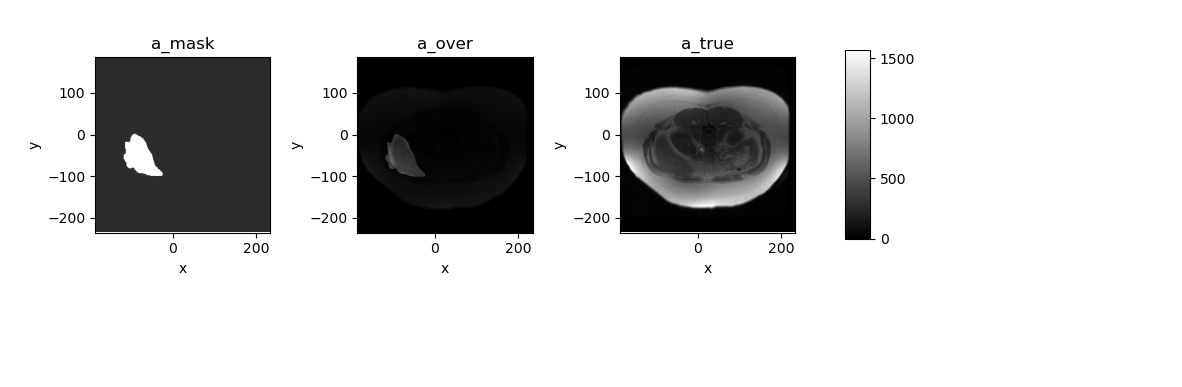

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


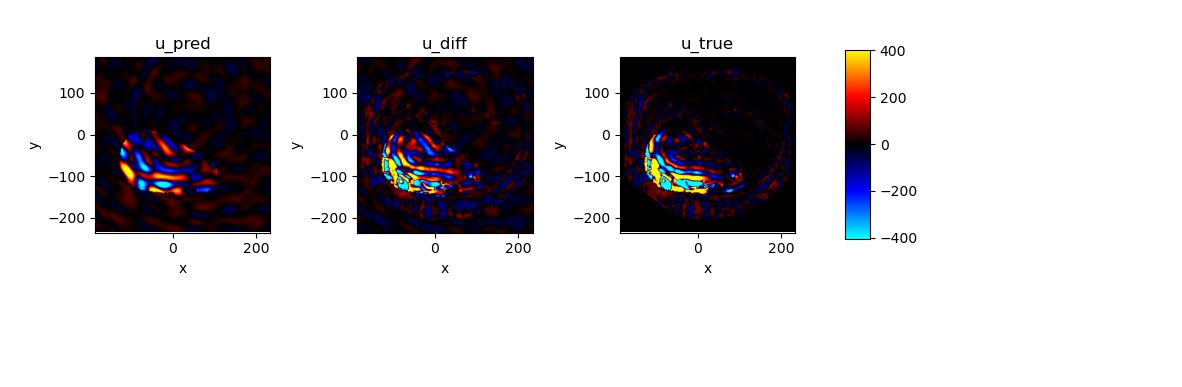

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


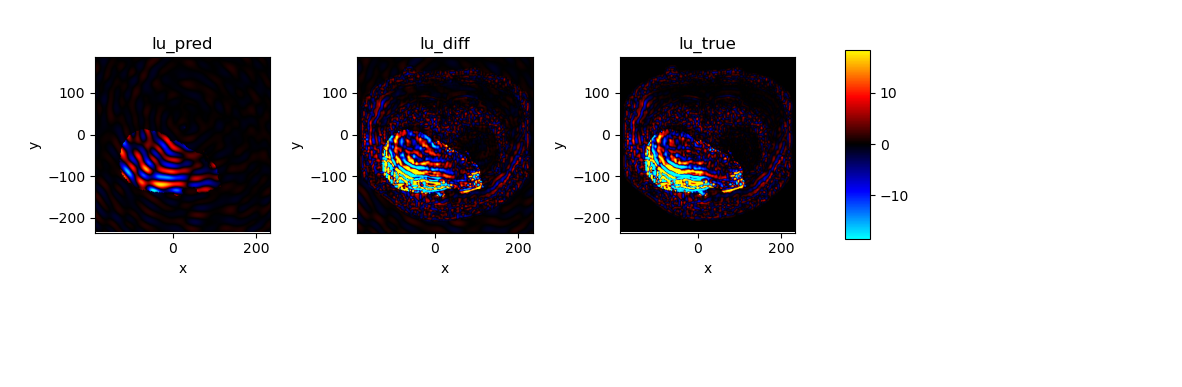

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

<IPython.core.display.Javascript object>


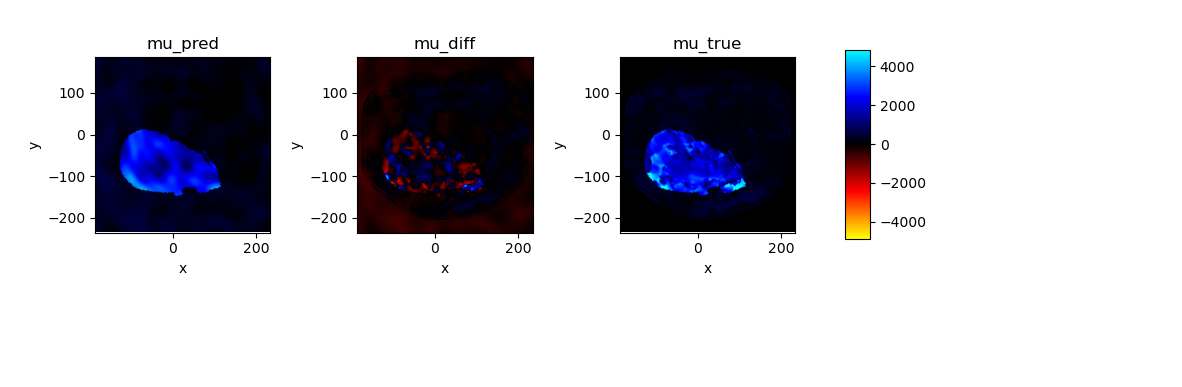

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

Time spent testing: 6.44%
10        [1.78e+04, 1.25e+04]    [2.59e+04, 6.58e+03]    []  
Time spent testing: 10.53%
20        [1.64e+04, 5.20e+03]    [2.82e+04, 5.89e+03]    []  
Time spent testing: 12.17%
30        [1.75e+04, 1.56e+04]    [2.25e+04, 4.74e+03]    []  
Time spent testing: 13.08%
40        [2.13e+04, 1.92e+04]    [2.22e+04, 5.14e+03]    []  
Time spent testing: 14.01%
50        [1.58e+04, 1.57e+04]    [1.94e+04, 4.95e+03]    []  
Time spent testing: 15.78%
60        [1.58e+04, 8.98e+03]    [2.05e+04, 4.45e+03]    []  
Time spent testing: 16.23%
70        [1.19e+04, 1.30e+04]    [1.93e+04, 4.75e+03]    []  
Time spent testing: 17.29%
80        [1.41e+04, 6.61e+03]    [1.81e+04, 4.87e+03]    []  
Time spent testing: 17.93%
90        [1.45e+04, 1.30e+04]    [1.67e+04, 4.83e+03]    []  
Time spent testing: 18.10%
100       [1.49e+04, 1.01e+04]    [1.68e+04, 4.47e+03]    []  
Time spent testing: 18.31%
110       [1.19e+04, 7.39e+03]    [1.76e+04, 4.62e+03]    []  
Time spent 

920       [9.83e+03, 4.38e+03]    [1.34e+04, 1.85e+03]    []  
Time spent testing: 22.45%
930       [9.21e+03, 2.53e+03]    [1.33e+04, 1.75e+03]    []  
Time spent testing: 22.43%
940       [9.06e+03, 3.73e+03]    [1.33e+04, 1.88e+03]    []  
Time spent testing: 22.40%
950       [7.90e+03, 4.82e+03]    [1.33e+04, 1.71e+03]    []  
Time spent testing: 22.37%
960       [7.31e+03, 4.56e+03]    [1.34e+04, 1.88e+03]    []  
Time spent testing: 22.35%
970       [7.97e+03, 5.47e+03]    [1.33e+04, 1.60e+03]    []  
Time spent testing: 22.32%
980       [8.87e+03, 4.26e+03]    [1.33e+04, 1.69e+03]    []  
Time spent testing: 22.68%
990       [1.16e+04, 2.37e+03]    [1.32e+04, 1.71e+03]    []  
Time spent testing: 22.66%
1000      [8.51e+03, 4.92e+03]    [1.32e+04, 1.60e+03]    []  
Time spent testing: 22.63%
1010      [8.15e+03, 3.50e+03]    [1.33e+04, 1.77e+03]    []  
Time spent testing: 22.60%
1020      [8.90e+03, 7.07e+03]    [1.32e+04, 1.65e+03]    []  
Time spent testing: 22.57%
1030      

Time spent testing: 21.36%
1840      [7.90e+03, 2.13e+03]    [1.25e+04, 1.62e+03]    []  
Time spent testing: 21.35%
1850      [7.24e+03, 5.96e+03]    [1.23e+04, 1.49e+03]    []  
Time spent testing: 21.35%
1860      [6.36e+03, 2.73e+03]    [1.24e+04, 1.44e+03]    []  
Time spent testing: 21.34%
1870      [6.59e+03, 4.73e+03]    [1.23e+04, 1.46e+03]    []  
Time spent testing: 21.33%
1880      [8.68e+03, 3.66e+03]    [1.23e+04, 1.54e+03]    []  
Time spent testing: 21.32%
1890      [6.44e+03, 3.70e+03]    [1.23e+04, 1.62e+03]    []  
Time spent testing: 21.31%
1900      [8.32e+03, 2.92e+03]    [1.23e+04, 1.55e+03]    []  
Time spent testing: 21.30%
1910      [7.79e+03, 3.92e+03]    [1.23e+04, 1.52e+03]    []  
Time spent testing: 21.29%
1920      [9.35e+03, 2.80e+03]    [1.23e+04, 1.50e+03]    []  
Time spent testing: 21.28%
1930      [7.60e+03, 1.68e+03]    [1.24e+04, 1.53e+03]    []  
Time spent testing: 21.28%
1940      [8.41e+03, 2.50e+03]    [1.25e+04, 1.51e+03]    []  
Time spent

2750      [5.22e+03, 2.60e+03]    [1.17e+04, 1.41e+03]    []  
Time spent testing: 20.82%
2760      [5.77e+03, 5.45e+03]    [1.20e+04, 1.43e+03]    []  
Time spent testing: 20.83%
2770      [6.23e+03, 3.42e+03]    [1.18e+04, 1.34e+03]    []  
Time spent testing: 20.83%
2780      [6.57e+03, 2.45e+03]    [1.17e+04, 1.41e+03]    []  
Time spent testing: 20.82%
2790      [8.76e+03, 1.96e+03]    [1.18e+04, 1.41e+03]    []  
Time spent testing: 20.82%
2800      [6.35e+03, 2.11e+03]    [1.19e+04, 1.46e+03]    []  
Time spent testing: 20.82%
2810      [6.34e+03, 2.33e+03]    [1.18e+04, 1.37e+03]    []  
Time spent testing: 20.81%
2820      [6.00e+03, 2.19e+03]    [1.18e+04, 1.45e+03]    []  
Time spent testing: 20.81%
2830      [6.72e+03, 2.62e+03]    [1.18e+04, 1.35e+03]    []  
Time spent testing: 20.81%
2840      [6.17e+03, 2.04e+03]    [1.17e+04, 1.50e+03]    []  
Time spent testing: 20.81%
2850      [7.15e+03, 2.89e+03]    [1.17e+04, 1.46e+03]    []  
Time spent testing: 20.80%
2860      

Time spent testing: 21.43%
3670      [6.28e+03, 1.96e+03]    [1.15e+04, 1.28e+03]    []  
Time spent testing: 21.43%
3680      [7.28e+03, 1.59e+03]    [1.15e+04, 1.39e+03]    []  
Time spent testing: 21.52%
3690      [5.75e+03, 2.04e+03]    [1.14e+04, 1.34e+03]    []  
Time spent testing: 21.57%
3700      [6.24e+03, 1.97e+03]    [1.15e+04, 1.31e+03]    []  
Time spent testing: 21.56%
3710      [6.64e+03, 4.43e+03]    [1.14e+04, 1.34e+03]    []  
Time spent testing: 21.54%
3720      [8.28e+03, 2.08e+03]    [1.15e+04, 1.27e+03]    []  
Time spent testing: 21.59%
3730      [6.94e+03, 2.52e+03]    [1.15e+04, 1.37e+03]    []  
Time spent testing: 21.61%
3740      [7.77e+03, 2.63e+03]    [1.14e+04, 1.26e+03]    []  
Time spent testing: 21.53%
3750      [6.81e+03, 1.77e+03]    [1.14e+04, 1.30e+03]    []  
Time spent testing: 21.59%
3760      [8.27e+03, 2.29e+03]    [1.14e+04, 1.28e+03]    []  
Time spent testing: 21.70%
3770      [4.70e+03, 2.87e+03]    [1.14e+04, 1.34e+03]    []  
Time spent

4580      [6.54e+03, 2.28e+03]    [1.11e+04, 1.27e+03]    []  
Time spent testing: 22.11%
4590      [7.36e+03, 1.83e+03]    [1.11e+04, 1.35e+03]    []  
Time spent testing: 22.11%
4600      [9.01e+03, 1.62e+03]    [1.11e+04, 1.25e+03]    []  
Time spent testing: 22.10%
4610      [5.45e+03, 2.35e+03]    [1.10e+04, 1.29e+03]    []  
Time spent testing: 22.10%
4620      [6.04e+03, 2.03e+03]    [1.10e+04, 1.25e+03]    []  
Time spent testing: 22.11%
4630      [7.40e+03, 2.93e+03]    [1.09e+04, 1.23e+03]    []  
Time spent testing: 22.08%
4640      [6.86e+03, 1.53e+03]    [1.10e+04, 1.23e+03]    []  
Time spent testing: 22.07%
4650      [5.94e+03, 1.89e+03]    [1.10e+04, 1.25e+03]    []  
Time spent testing: 22.11%
4660      [6.12e+03, 1.69e+03]    [1.09e+04, 1.26e+03]    []  
Time spent testing: 22.15%
4670      [5.78e+03, 1.41e+03]    [1.11e+04, 1.33e+03]    []  
Time spent testing: 22.15%
4680      [6.71e+03, 3.41e+03]    [1.10e+04, 1.28e+03]    []  
Time spent testing: 22.15%
4690      

Time spent testing: 22.33%
5500      [8.61e+03, 1.97e+03]    [1.10e+04, 1.29e+03]    []  
Time spent testing: 22.33%
5510      [7.07e+03, 1.87e+03]    [1.08e+04, 1.23e+03]    []  
Time spent testing: 22.33%
5520      [7.41e+03, 2.49e+03]    [1.08e+04, 1.27e+03]    []  
Time spent testing: 22.28%
5530      [8.38e+03, 1.90e+03]    [1.09e+04, 1.25e+03]    []  
Time spent testing: 22.29%
5540      [5.30e+03, 3.85e+03]    [1.08e+04, 1.21e+03]    []  
Time spent testing: 22.31%
5550      [6.90e+03, 1.85e+03]    [1.07e+04, 1.24e+03]    []  
Time spent testing: 22.37%
5560      [6.11e+03, 1.72e+03]    [1.07e+04, 1.17e+03]    []  
Time spent testing: 22.38%
5570      [6.80e+03, 3.09e+03]    [1.07e+04, 1.18e+03]    []  
Time spent testing: 22.37%
5580      [4.75e+03, 2.44e+03]    [1.07e+04, 1.20e+03]    []  
Time spent testing: 22.41%
5590      [8.55e+03, 2.06e+03]    [1.07e+04, 1.18e+03]    []  
Time spent testing: 22.39%
5600      [4.58e+03, 2.21e+03]    [1.07e+04, 1.20e+03]    []  
Time spent

6410      [6.11e+03, 2.11e+03]    [1.05e+04, 1.19e+03]    []  
Time spent testing: 22.10%
6420      [6.56e+03, 2.27e+03]    [1.04e+04, 1.19e+03]    []  
Time spent testing: 22.11%
6430      [6.68e+03, 1.66e+03]    [1.06e+04, 1.29e+03]    []  
Time spent testing: 22.10%
6440      [7.48e+03, 2.89e+03]    [1.05e+04, 1.24e+03]    []  
Time spent testing: 22.10%
6450      [8.44e+03, 1.61e+03]    [1.05e+04, 1.18e+03]    []  
Time spent testing: 22.09%
6460      [8.59e+03, 1.74e+03]    [1.06e+04, 1.22e+03]    []  
Time spent testing: 22.09%
6470      [5.93e+03, 2.56e+03]    [1.04e+04, 1.15e+03]    []  
Time spent testing: 22.09%
6480      [7.85e+03, 1.66e+03]    [1.05e+04, 1.17e+03]    []  
Time spent testing: 22.09%
6490      [7.56e+03, 2.30e+03]    [1.05e+04, 1.18e+03]    []  
Time spent testing: 22.08%
6500      [4.60e+03, 2.21e+03]    [1.04e+04, 1.21e+03]    []  
Time spent testing: 22.08%
6510      [5.11e+03, 2.51e+03]    [1.05e+04, 1.15e+03]    []  
Time spent testing: 22.07%
6520      

Time spent testing: 21.88%
7330      [5.20e+03, 1.49e+03]    [1.02e+04, 1.12e+03]    []  
Time spent testing: 21.89%
7340      [8.29e+03, 1.59e+03]    [1.02e+04, 1.19e+03]    []  
Time spent testing: 21.92%
7350      [5.01e+03, 3.31e+03]    [1.02e+04, 1.17e+03]    []  
Time spent testing: 21.94%
7360      [8.50e+03, 1.91e+03]    [1.03e+04, 1.16e+03]    []  
Time spent testing: 21.94%
7370      [7.13e+03, 1.78e+03]    [1.03e+04, 1.17e+03]    []  
Time spent testing: 21.95%
7380      [6.11e+03, 1.88e+03]    [1.03e+04, 1.14e+03]    []  
Time spent testing: 21.93%
7390      [5.21e+03, 2.13e+03]    [1.03e+04, 1.18e+03]    []  
Time spent testing: 21.95%
7400      [4.92e+03, 2.10e+03]    [1.02e+04, 1.13e+03]    []  
Time spent testing: 21.94%
7410      [6.38e+03, 2.13e+03]    [1.03e+04, 1.14e+03]    []  
Time spent testing: 21.94%
7420      [6.17e+03, 1.84e+03]    [1.03e+04, 1.18e+03]    []  
Time spent testing: 21.94%
7430      [8.20e+03, 2.00e+03]    [1.02e+04, 1.16e+03]    []  
Time spent

8240      [8.32e+03, 1.13e+03]    [9.95e+03, 1.12e+03]    []  
Time spent testing: 21.90%
8250      [6.25e+03, 1.48e+03]    [1.00e+04, 1.08e+03]    []  
Time spent testing: 21.90%
8260      [6.14e+03, 2.96e+03]    [1.00e+04, 1.09e+03]    []  
Time spent testing: 21.89%
8270      [5.66e+03, 1.14e+03]    [9.96e+03, 1.09e+03]    []  
Time spent testing: 21.87%
8280      [6.87e+03, 1.41e+03]    [9.99e+03, 1.14e+03]    []  
Time spent testing: 21.88%
8290      [6.65e+03, 1.58e+03]    [1.00e+04, 1.11e+03]    []  
Time spent testing: 21.91%
8300      [6.73e+03, 1.26e+03]    [1.01e+04, 1.22e+03]    []  
Time spent testing: 21.91%
8310      [4.95e+03, 1.24e+03]    [1.01e+04, 1.11e+03]    []  
Time spent testing: 21.92%
8320      [6.26e+03, 1.44e+03]    [1.00e+04, 1.28e+03]    []  
Time spent testing: 21.92%
8330      [8.11e+03, 1.50e+03]    [1.01e+04, 1.21e+03]    []  
Time spent testing: 21.92%
8340      [6.99e+03, 1.44e+03]    [1.00e+04, 1.13e+03]    []  
Time spent testing: 21.91%
8350      

Time spent testing: 21.75%
9160      [8.00e+03, 1.27e+03]    [9.83e+03, 1.07e+03]    []  
Time spent testing: 21.76%
9170      [4.99e+03, 1.47e+03]    [9.82e+03, 1.05e+03]    []  
Time spent testing: 21.75%
9180      [6.44e+03, 2.31e+03]    [9.83e+03, 1.08e+03]    []  
Time spent testing: 21.75%
9190      [6.34e+03, 2.39e+03]    [9.81e+03, 1.09e+03]    []  
Time spent testing: 21.76%
9200      [4.15e+03, 1.40e+03]    [9.87e+03, 1.09e+03]    []  
Time spent testing: 21.76%
9210      [7.88e+03, 2.60e+03]    [9.80e+03, 1.06e+03]    []  
Time spent testing: 21.76%
9220      [4.71e+03, 1.71e+03]    [9.84e+03, 1.11e+03]    []  
Time spent testing: 21.74%
9230      [5.91e+03, 2.19e+03]    [9.83e+03, 1.15e+03]    []  
Time spent testing: 21.72%
9240      [5.48e+03, 1.44e+03]    [9.81e+03, 1.08e+03]    []  
Time spent testing: 21.69%
9250      [7.14e+03, 1.89e+03]    [9.85e+03, 1.08e+03]    []  
Time spent testing: 21.70%
9260      [5.47e+03, 1.95e+03]    [9.83e+03, 1.12e+03]    []  
Time spent

10070     [5.89e+03, 2.25e+03]    [9.66e+03, 1.04e+03]    []  
Time spent testing: 21.66%
10080     [7.21e+03, 2.03e+03]    [9.61e+03, 1.03e+03]    []  
Time spent testing: 21.65%
10090     [5.33e+03, 2.01e+03]    [9.64e+03, 1.06e+03]    []  
Time spent testing: 21.66%
10100     [5.93e+03, 1.47e+03]    [9.66e+03, 1.02e+03]    []  
Time spent testing: 21.66%
10110     [6.59e+03, 2.71e+03]    [9.65e+03, 1.03e+03]    []  
Time spent testing: 21.66%
10120     [5.74e+03, 1.61e+03]    [9.69e+03, 1.06e+03]    []  
Time spent testing: 21.62%
10130     [5.73e+03, 2.22e+03]    [9.61e+03, 1.02e+03]    []  
Time spent testing: 21.63%
10140     [4.72e+03, 1.08e+03]    [9.61e+03, 1.05e+03]    []  
Time spent testing: 21.63%
10150     [5.18e+03, 1.40e+03]    [9.57e+03, 1.03e+03]    []  
Time spent testing: 21.63%
10160     [7.33e+03, 1.55e+03]    [9.65e+03, 1.06e+03]    []  
Time spent testing: 21.62%
10170     [5.98e+03, 1.48e+03]    [9.56e+03, 1.03e+03]    []  
Time spent testing: 21.63%
10180     

Time spent testing: 21.44%
10990     [6.00e+03, 1.48e+03]    [9.55e+03, 1.03e+03]    []  
Time spent testing: 21.43%
11000     [5.35e+03, 1.41e+03]    [9.51e+03, 1.02e+03]    []  
Time spent testing: 21.41%
11010     [4.49e+03, 3.67e+03]    [9.48e+03, 9.99e+02]    []  
Time spent testing: 21.42%
11020     [5.57e+03, 2.67e+03]    [9.59e+03, 1.04e+03]    []  
Time spent testing: 21.41%
11030     [5.28e+03, 1.81e+03]    [9.42e+03, 9.97e+02]    []  
Time spent testing: 21.42%
11040     [5.46e+03, 1.65e+03]    [9.51e+03, 1.05e+03]    []  
Time spent testing: 21.41%
11050     [5.36e+03, 1.72e+03]    [9.48e+03, 1.04e+03]    []  
Time spent testing: 21.39%
11060     [8.25e+03, 1.35e+03]    [9.56e+03, 1.03e+03]    []  
Time spent testing: 21.40%
11070     [5.63e+03, 2.18e+03]    [9.55e+03, 1.04e+03]    []  
Time spent testing: 21.42%
11080     [6.66e+03, 2.73e+03]    [9.52e+03, 1.02e+03]    []  
Time spent testing: 21.43%
11090     [5.07e+03, 2.28e+03]    [9.57e+03, 1.03e+03]    []  
Time spent

11900     [6.16e+03, 1.69e+03]    [9.31e+03, 9.95e+02]    []  
Time spent testing: 21.41%
11910     [5.68e+03, 1.79e+03]    [9.30e+03, 1.02e+03]    []  
Time spent testing: 21.41%
11920     [4.15e+03, 2.96e+03]    [9.28e+03, 1.00e+03]    []  
Time spent testing: 21.40%
11930     [7.26e+03, 1.27e+03]    [9.31e+03, 9.87e+02]    []  
Time spent testing: 21.40%
11940     [6.44e+03, 1.24e+03]    [9.30e+03, 9.87e+02]    []  
Time spent testing: 21.40%
11950     [6.98e+03, 1.19e+03]    [9.42e+03, 1.01e+03]    []  
Time spent testing: 21.40%
11960     [6.03e+03, 1.77e+03]    [9.31e+03, 1.03e+03]    []  
Time spent testing: 21.40%
11970     [5.68e+03, 1.77e+03]    [9.48e+03, 1.07e+03]    []  
Time spent testing: 21.40%
11980     [6.97e+03, 1.57e+03]    [9.28e+03, 1.00e+03]    []  
Time spent testing: 21.40%
11990     [5.46e+03, 1.16e+03]    [9.33e+03, 1.03e+03]    []  
Time spent testing: 21.40%
12000     [5.34e+03, 2.43e+03]    [9.40e+03, 1.01e+03]    []  
Time spent testing: 21.39%
12010     

Time spent testing: 21.25%
12820     [6.83e+03, 2.66e+03]    [9.14e+03, 9.69e+02]    []  
Time spent testing: 21.27%
12830     [4.61e+03, 1.28e+03]    [9.14e+03, 9.60e+02]    []  
Time spent testing: 21.27%
12840     [5.67e+03, 9.30e+02]    [9.20e+03, 9.65e+02]    []  
Time spent testing: 21.25%
12850     [6.10e+03, 1.32e+03]    [9.20e+03, 9.95e+02]    []  
Time spent testing: 21.26%
12860     [6.40e+03, 1.65e+03]    [9.25e+03, 1.07e+03]    []  
Time spent testing: 21.26%
12870     [3.80e+03, 1.76e+03]    [9.15e+03, 9.59e+02]    []  
Time spent testing: 21.26%
12880     [7.31e+03, 1.36e+03]    [9.25e+03, 1.04e+03]    []  
Time spent testing: 21.26%
12890     [5.94e+03, 1.33e+03]    [9.30e+03, 1.02e+03]    []  
Time spent testing: 21.24%
12900     [6.01e+03, 1.08e+03]    [9.17e+03, 9.48e+02]    []  
Time spent testing: 21.25%
12910     [4.77e+03, 2.03e+03]    [9.28e+03, 1.01e+03]    []  
Time spent testing: 21.25%
12920     [6.01e+03, 1.20e+03]    [9.18e+03, 9.63e+02]    []  
Time spent

13730     [4.26e+03, 2.26e+03]    [9.14e+03, 9.47e+02]    []  
Time spent testing: 21.19%
13740     [5.03e+03, 1.44e+03]    [9.19e+03, 9.66e+02]    []  
Time spent testing: 21.19%
13750     [4.05e+03, 1.19e+03]    [9.06e+03, 9.46e+02]    []  
Time spent testing: 21.19%
13760     [7.67e+03, 1.13e+03]    [9.20e+03, 9.90e+02]    []  
Time spent testing: 21.19%
13770     [4.33e+03, 2.18e+03]    [9.15e+03, 1.00e+03]    []  
Time spent testing: 21.17%
13780     [5.87e+03, 1.23e+03]    [9.12e+03, 9.54e+02]    []  
Time spent testing: 21.18%
13790     [4.08e+03, 2.91e+03]    [9.12e+03, 9.93e+02]    []  
Time spent testing: 21.18%
13800     [7.12e+03, 1.40e+03]    [9.10e+03, 9.58e+02]    []  
Time spent testing: 21.16%
13810     [3.46e+03, 2.66e+03]    [9.10e+03, 9.78e+02]    []  
Time spent testing: 21.17%
13820     [5.91e+03, 1.49e+03]    [9.10e+03, 1.01e+03]    []  
Time spent testing: 21.18%
13830     [6.95e+03, 2.59e+03]    [9.15e+03, 9.22e+02]    []  
Time spent testing: 21.18%
13840     

Time spent testing: 21.22%
14650     [3.99e+03, 1.21e+03]    [9.08e+03, 9.97e+02]    []  
Time spent testing: 21.21%
14660     [4.76e+03, 1.53e+03]    [9.10e+03, 9.99e+02]    []  
Time spent testing: 21.22%
14670     [6.64e+03, 1.10e+03]    [9.00e+03, 9.35e+02]    []  
Time spent testing: 21.22%
14680     [6.47e+03, 1.23e+03]    [8.97e+03, 9.45e+02]    []  
Time spent testing: 21.22%
14690     [5.60e+03, 1.12e+03]    [8.98e+03, 9.50e+02]    []  
Time spent testing: 21.21%
14700     [6.12e+03, 1.25e+03]    [8.95e+03, 9.52e+02]    []  
Time spent testing: 21.20%
14710     [5.56e+03, 1.25e+03]    [8.98e+03, 9.31e+02]    []  
Time spent testing: 21.21%
14720     [5.91e+03, 1.75e+03]    [8.97e+03, 9.50e+02]    []  
Time spent testing: 21.21%
14730     [5.57e+03, 1.32e+03]    [8.97e+03, 9.56e+02]    []  
Time spent testing: 21.21%
14740     [4.87e+03, 1.64e+03]    [8.94e+03, 9.20e+02]    []  
Time spent testing: 21.20%
14750     [3.84e+03, 1.83e+03]    [8.91e+03, 9.50e+02]    []  
Time spent

15560     [7.04e+03, 1.71e+03]    [8.86e+03, 9.29e+02]    []  
Time spent testing: 21.17%
15570     [4.48e+03, 1.49e+03]    [8.84e+03, 9.10e+02]    []  
Time spent testing: 21.18%
15580     [4.84e+03, 2.69e+03]    [8.83e+03, 9.34e+02]    []  
Time spent testing: 21.19%
15590     [5.71e+03, 1.13e+03]    [9.07e+03, 1.01e+03]    []  
Time spent testing: 21.19%
15600     [4.61e+03, 1.72e+03]    [9.13e+03, 9.69e+02]    []  
Time spent testing: 21.19%
15610     [4.63e+03, 1.75e+03]    [8.88e+03, 9.05e+02]    []  
Time spent testing: 21.18%
15620     [5.47e+03, 2.21e+03]    [8.85e+03, 9.22e+02]    []  
Time spent testing: 21.18%
15630     [3.35e+03, 1.81e+03]    [8.82e+03, 9.32e+02]    []  
Time spent testing: 21.18%
15640     [6.89e+03, 1.09e+03]    [8.85e+03, 9.32e+02]    []  
Time spent testing: 21.18%
15650     [6.56e+03, 2.72e+03]    [8.80e+03, 9.29e+02]    []  
Time spent testing: 21.18%
15660     [6.72e+03, 1.30e+03]    [8.76e+03, 9.33e+02]    []  
Time spent testing: 21.16%
15670     

Time spent testing: 21.10%
16480     [6.92e+03, 7.30e+02]    [8.73e+03, 9.12e+02]    []  
Time spent testing: 21.09%
16490     [4.87e+03, 2.24e+03]    [8.70e+03, 8.85e+02]    []  
Time spent testing: 21.10%
16500     [5.17e+03, 1.10e+03]    [8.67e+03, 8.97e+02]    []  
Time spent testing: 21.08%
16510     [4.81e+03, 9.47e+02]    [8.82e+03, 9.52e+02]    []  
Time spent testing: 21.09%
16520     [5.11e+03, 2.15e+03]    [8.70e+03, 9.21e+02]    []  
Time spent testing: 21.10%
16530     [4.41e+03, 1.16e+03]    [8.72e+03, 9.18e+02]    []  
Time spent testing: 21.10%
16540     [2.88e+03, 2.14e+03]    [8.74e+03, 9.26e+02]    []  
Time spent testing: 21.10%
16550     [4.15e+03, 2.11e+03]    [8.71e+03, 8.95e+02]    []  
Time spent testing: 21.10%
16560     [4.13e+03, 1.30e+03]    [8.72e+03, 9.19e+02]    []  
Time spent testing: 21.11%
16570     [6.85e+03, 1.36e+03]    [8.77e+03, 9.33e+02]    []  
Time spent testing: 21.11%
16580     [5.34e+03, 1.14e+03]    [8.77e+03, 9.12e+02]    []  
Time spent

17390     [5.13e+03, 8.18e+02]    [8.61e+03, 8.97e+02]    []  
Time spent testing: 21.07%
17400     [6.86e+03, 9.29e+02]    [8.64e+03, 9.07e+02]    []  
Time spent testing: 21.06%
17410     [4.41e+03, 1.57e+03]    [8.70e+03, 8.94e+02]    []  
Time spent testing: 21.07%
17420     [5.64e+03, 1.11e+03]    [8.71e+03, 8.93e+02]    []  
Time spent testing: 21.07%
17430     [5.38e+03, 1.16e+03]    [8.68e+03, 9.03e+02]    []  
Time spent testing: 21.07%
17440     [5.50e+03, 1.48e+03]    [8.61e+03, 8.74e+02]    []  
Time spent testing: 21.07%
17450     [3.83e+03, 1.65e+03]    [8.73e+03, 9.14e+02]    []  
Time spent testing: 21.07%
17460     [4.53e+03, 1.46e+03]    [8.68e+03, 9.23e+02]    []  
Time spent testing: 21.05%
17470     [5.03e+03, 1.54e+03]    [8.66e+03, 9.22e+02]    []  
Time spent testing: 21.06%
17480     [4.73e+03, 3.17e+03]    [8.62e+03, 9.01e+02]    []  
Time spent testing: 21.06%
17490     [5.14e+03, 1.92e+03]    [8.60e+03, 8.93e+02]    []  
Time spent testing: 21.06%
17500     

Time spent testing: 21.05%
18310     [4.64e+03, 1.45e+03]    [8.52e+03, 8.73e+02]    []  
Time spent testing: 21.04%
18320     [5.51e+03, 1.64e+03]    [8.52e+03, 8.96e+02]    []  
Time spent testing: 21.04%
18330     [5.18e+03, 9.20e+02]    [8.50e+03, 8.82e+02]    []  
Time spent testing: 21.03%
18340     [7.45e+03, 3.31e+03]    [8.54e+03, 8.71e+02]    []  
Time spent testing: 21.04%
18350     [4.01e+03, 1.09e+03]    [8.55e+03, 8.97e+02]    []  
Time spent testing: 21.03%
18360     [4.57e+03, 1.27e+03]    [8.57e+03, 8.99e+02]    []  
Time spent testing: 21.04%
18370     [7.67e+03, 1.10e+03]    [8.62e+03, 8.94e+02]    []  
Time spent testing: 21.04%
18380     [4.32e+03, 1.15e+03]    [8.57e+03, 8.89e+02]    []  
Time spent testing: 21.03%
18390     [4.65e+03, 1.98e+03]    [8.54e+03, 8.91e+02]    []  
Time spent testing: 21.04%
18400     [4.08e+03, 1.33e+03]    [8.55e+03, 8.63e+02]    []  
Time spent testing: 21.04%
18410     [5.54e+03, 1.66e+03]    [8.59e+03, 9.09e+02]    []  
Time spent

19220     [5.21e+03, 1.97e+03]    [8.42e+03, 8.65e+02]    []  
Time spent testing: 21.11%
19230     [4.79e+03, 1.55e+03]    [8.47e+03, 8.82e+02]    []  
Time spent testing: 21.11%
19240     [4.72e+03, 9.59e+02]    [8.45e+03, 8.78e+02]    []  
Time spent testing: 21.10%
19250     [4.54e+03, 8.43e+02]    [8.51e+03, 8.81e+02]    []  
Time spent testing: 21.09%
19260     [4.54e+03, 1.74e+03]    [8.46e+03, 8.85e+02]    []  
Time spent testing: 21.10%
19270     [6.32e+03, 1.36e+03]    [8.40e+03, 8.74e+02]    []  
Time spent testing: 21.10%
19280     [5.58e+03, 1.91e+03]    [8.47e+03, 8.67e+02]    []  
Time spent testing: 21.09%
19290     [3.04e+03, 2.14e+03]    [8.44e+03, 8.60e+02]    []  
Time spent testing: 21.10%
19300     [7.56e+03, 1.18e+03]    [8.44e+03, 8.61e+02]    []  
Time spent testing: 21.10%
19310     [4.90e+03, 1.23e+03]    [8.47e+03, 8.86e+02]    []  
Time spent testing: 21.10%
19320     [5.79e+03, 2.39e+03]    [8.48e+03, 8.78e+02]    []  
Time spent testing: 21.10%
19330     

Time spent testing: 21.01%
20140     [5.82e+03, 2.74e+03]    [8.34e+03, 8.56e+02]    []  
Time spent testing: 21.02%
20150     [4.76e+03, 8.57e+02]    [8.38e+03, 9.05e+02]    []  
Time spent testing: 21.03%
20160     [4.47e+03, 2.29e+03]    [8.47e+03, 9.46e+02]    []  
Time spent testing: 21.03%
20170     [3.85e+03, 1.43e+03]    [8.37e+03, 8.67e+02]    []  
Time spent testing: 21.03%
20180     [5.07e+03, 1.82e+03]    [8.34e+03, 8.54e+02]    []  
Time spent testing: 21.03%
20190     [5.29e+03, 1.83e+03]    [8.36e+03, 8.55e+02]    []  
Time spent testing: 21.03%
20200     [6.31e+03, 1.80e+03]    [8.31e+03, 8.82e+02]    []  
Time spent testing: 21.03%
20210     [3.74e+03, 2.22e+03]    [8.36e+03, 8.67e+02]    []  
Time spent testing: 21.03%
20220     [4.93e+03, 1.48e+03]    [8.36e+03, 8.68e+02]    []  
Time spent testing: 21.03%
20230     [5.62e+03, 1.08e+03]    [8.36e+03, 8.78e+02]    []  
Time spent testing: 21.02%
20240     [4.39e+03, 1.93e+03]    [8.33e+03, 8.65e+02]    []  
Time spent

21050     [5.92e+03, 1.24e+03]    [8.25e+03, 8.32e+02]    []  
Time spent testing: 21.02%
21060     [6.25e+03, 2.44e+03]    [8.24e+03, 8.64e+02]    []  
Time spent testing: 21.02%
21070     [5.59e+03, 2.45e+03]    [8.24e+03, 8.56e+02]    []  
Time spent testing: 21.02%
21080     [5.57e+03, 9.05e+02]    [8.25e+03, 8.48e+02]    []  
Time spent testing: 21.02%
21090     [6.89e+03, 2.52e+03]    [8.26e+03, 8.52e+02]    []  
Time spent testing: 21.02%
21100     [5.19e+03, 8.84e+02]    [8.24e+03, 8.45e+02]    []  
Time spent testing: 21.02%
21110     [6.84e+03, 9.43e+02]    [8.28e+03, 8.57e+02]    []  
Time spent testing: 21.02%
21120     [4.07e+03, 2.55e+03]    [8.28e+03, 8.40e+02]    []  
Time spent testing: 21.02%
21130     [5.38e+03, 3.18e+03]    [8.28e+03, 8.40e+02]    []  
Time spent testing: 21.03%
21140     [6.55e+03, 1.46e+03]    [8.28e+03, 8.47e+02]    []  
Time spent testing: 21.03%
21150     [4.73e+03, 1.78e+03]    [8.30e+03, 8.54e+02]    []  
Time spent testing: 21.03%
21160     

Time spent testing: 21.02%
21970     [5.55e+03, 1.10e+03]    [8.21e+03, 8.44e+02]    []  
Time spent testing: 21.02%
21980     [5.40e+03, 1.07e+03]    [8.24e+03, 8.88e+02]    []  
Time spent testing: 21.02%
21990     [6.62e+03, 1.47e+03]    [8.25e+03, 8.67e+02]    []  
Time spent testing: 21.03%
22000     [4.76e+03, 2.00e+03]    [8.21e+03, 8.32e+02]    []  
Time spent testing: 21.03%
22010     [3.69e+03, 1.28e+03]    [8.18e+03, 8.67e+02]    []  
Time spent testing: 21.02%
22020     [7.15e+03, 1.08e+03]    [8.24e+03, 8.51e+02]    []  
Time spent testing: 21.02%
22030     [4.15e+03, 9.86e+02]    [8.33e+03, 8.43e+02]    []  
Time spent testing: 21.01%
22040     [4.41e+03, 1.45e+03]    [8.20e+03, 8.41e+02]    []  
Time spent testing: 21.02%
22050     [3.82e+03, 1.32e+03]    [8.18e+03, 8.59e+02]    []  
Time spent testing: 21.02%
22060     [4.99e+03, 1.91e+03]    [8.49e+03, 8.65e+02]    []  
Time spent testing: 21.02%
22070     [3.62e+03, 2.18e+03]    [8.24e+03, 8.48e+02]    []  
Time spent

22880     [6.08e+03, 2.19e+03]    [8.11e+03, 8.34e+02]    []  
Time spent testing: 20.94%
22890     [5.22e+03, 1.71e+03]    [8.14e+03, 8.26e+02]    []  
Time spent testing: 20.95%
22900     [5.41e+03, 1.08e+03]    [8.23e+03, 8.24e+02]    []  
Time spent testing: 20.95%
22910     [4.73e+03, 1.09e+03]    [8.12e+03, 8.44e+02]    []  
Time spent testing: 20.95%
22920     [5.35e+03, 1.96e+03]    [8.16e+03, 8.52e+02]    []  
Time spent testing: 20.95%
22930     [5.07e+03, 1.41e+03]    [8.10e+03, 8.39e+02]    []  
Time spent testing: 20.94%
22940     [5.18e+03, 1.04e+03]    [8.19e+03, 8.65e+02]    []  
Time spent testing: 20.95%
22950     [4.54e+03, 1.24e+03]    [8.13e+03, 8.25e+02]    []  
Time spent testing: 20.94%
22960     [4.47e+03, 9.87e+02]    [8.16e+03, 8.48e+02]    []  
Time spent testing: 20.94%
22970     [4.48e+03, 9.11e+02]    [8.11e+03, 8.33e+02]    []  
Time spent testing: 20.94%
22980     [4.12e+03, 2.28e+03]    [8.11e+03, 8.22e+02]    []  
Time spent testing: 20.94%
22990     

Time spent testing: 20.99%
23800     [5.56e+03, 1.11e+03]    [8.07e+03, 8.32e+02]    []  
Time spent testing: 20.99%
23810     [5.81e+03, 7.80e+02]    [8.03e+03, 8.10e+02]    []  
Time spent testing: 20.99%
23820     [5.71e+03, 8.07e+02]    [8.02e+03, 8.12e+02]    []  
Time spent testing: 20.99%
23830     [4.47e+03, 1.24e+03]    [8.04e+03, 8.14e+02]    []  
Time spent testing: 21.00%
23840     [4.79e+03, 9.60e+02]    [8.07e+03, 8.53e+02]    []  
Time spent testing: 21.00%
23850     [3.88e+03, 1.38e+03]    [8.03e+03, 8.00e+02]    []  
Time spent testing: 21.00%
23860     [5.66e+03, 1.45e+03]    [8.09e+03, 7.97e+02]    []  
Time spent testing: 21.00%
23870     [3.31e+03, 2.30e+03]    [8.03e+03, 8.14e+02]    []  
Time spent testing: 21.00%
23880     [5.26e+03, 1.00e+03]    [7.99e+03, 8.05e+02]    []  
Time spent testing: 21.00%
23890     [4.57e+03, 1.32e+03]    [8.10e+03, 8.66e+02]    []  
Time spent testing: 21.00%
23900     [5.20e+03, 9.73e+02]    [8.03e+03, 8.21e+02]    []  
Time spent

24710     [4.35e+03, 1.34e+03]    [7.96e+03, 7.98e+02]    []  
Time spent testing: 20.96%
24720     [3.43e+03, 1.25e+03]    [7.98e+03, 8.21e+02]    []  
Time spent testing: 20.96%
24730     [4.70e+03, 1.27e+03]    [7.95e+03, 8.19e+02]    []  
Time spent testing: 20.96%
24740     [6.20e+03, 1.41e+03]    [8.01e+03, 8.29e+02]    []  
Time spent testing: 20.96%
24750     [3.75e+03, 1.33e+03]    [7.96e+03, 8.03e+02]    []  
Time spent testing: 20.97%
24760     [4.51e+03, 1.07e+03]    [7.96e+03, 8.10e+02]    []  
Time spent testing: 20.97%
24770     [6.48e+03, 2.15e+03]    [8.00e+03, 8.04e+02]    []  
Time spent testing: 20.97%
24780     [5.24e+03, 1.07e+03]    [8.04e+03, 8.07e+02]    []  
Time spent testing: 20.97%
24790     [4.46e+03, 1.25e+03]    [7.98e+03, 8.26e+02]    []  
Time spent testing: 20.97%
24800     [6.25e+03, 1.05e+03]    [7.95e+03, 8.00e+02]    []  
Time spent testing: 20.97%
24810     [4.99e+03, 1.62e+03]    [7.97e+03, 8.04e+02]    []  
Time spent testing: 20.96%
24820     

Time spent testing: 20.96%
25630     [4.83e+03, 7.87e+02]    [7.90e+03, 7.96e+02]    []  
Time spent testing: 20.96%
25640     [3.37e+03, 1.57e+03]    [7.91e+03, 7.97e+02]    []  
Time spent testing: 20.95%
25650     [4.86e+03, 1.48e+03]    [7.90e+03, 8.09e+02]    []  
Time spent testing: 20.95%
25660     [5.69e+03, 9.79e+02]    [7.93e+03, 8.06e+02]    []  
Time spent testing: 20.95%
25670     [4.19e+03, 2.25e+03]    [7.94e+03, 8.15e+02]    []  
Time spent testing: 20.95%
25680     [4.66e+03, 1.36e+03]    [8.03e+03, 8.09e+02]    []  
Time spent testing: 20.95%
25690     [5.42e+03, 9.68e+02]    [7.89e+03, 7.94e+02]    []  
Time spent testing: 20.94%
25700     [6.20e+03, 1.17e+03]    [7.88e+03, 7.85e+02]    []  
Time spent testing: 20.95%
25710     [4.44e+03, 1.04e+03]    [7.92e+03, 7.86e+02]    []  
Time spent testing: 20.95%
25720     [4.14e+03, 1.58e+03]    [7.93e+03, 7.93e+02]    []  
Time spent testing: 20.95%
25730     [6.25e+03, 1.02e+03]    [7.88e+03, 7.97e+02]    []  
Time spent

In [ ]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

model.train(100000, display_every=10, callbacks=[test_eval])